In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin
import random

In [2]:
def sign(a):
  return (a>=0)*2-1

def accuracy(yactual,ypred):
  return sum(yactual==ypred)/len(yactual)

In [129]:
from abc import ABC, abstractmethod,abstractstaticmethod
from scipy.special import expit

class TrainingAlgorithm(ABC):
  
  @abstractmethod
  def getW(self,X,y):
    pass

class Custo(ABC):
  @abstractstaticmethod
  def custo(y,ypred):
    pass
  @abstractstaticmethod
  def gradiente(y,ypred):
    pass


class WidrowHoff(Custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum((y - ypred)**2)
  
  @staticmethod
  def gradiente(y,ypred):
    return y - ypred

class SmoothedSurrogate(Custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.maximum(np.zeros(y.shape),-y*ypred))

  @staticmethod
  def gradiente(y,ypred):
    return y - sign(ypred)


class HingeLoss(Custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.maximum(np.zeros(y.shape),1-y*ypred))
  @staticmethod
  def gradiente(y,ypred):
    errosmarginais = (y*ypred)<1
    ymarginais = np.copy(y)
    ymarginais[~errosmarginais] = 0
    return ymarginais



class LogLikehood(Custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.log(1+np.exp(-y*ypred)))
  
  @staticmethod
  def gradiente(y,ypred):
    return y-(expit(ypred)*2-1)

class PseudoInversa(TrainingAlgorithm):
  def __init__(self,history=[0]):
    self.history = history[0]
    
  def getW(self,X,y):
    return np.linalg.pinv(X) @ y


class PseudoInversaReg(TrainingAlgorithm):
  def __init__(self,history=[0],regularization=0):
    self.history = history[0]
    self.regularization = regularization
    
  def getW(self,X,y):
    w = np.linalg.inv(X.T @ X + np.identity(X.shape[1])*self.regularization) @ X.T @ y
    return w




class DescidaGradiente(TrainingAlgorithm):
  def __init__(self,max_iter=1000,learning_rate=0.01,early_stop=0,regularization=0.1,cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.early_stop = early_stop
    self.history=[]
    self.cost = cost

  def getW(self,X,y):
    w = np.random.uniform(-1,1,size=X.shape[1])
    for j in range(self.max_iter):
      ypred = X @ w
      #erros = y - ypred
      custo = self.cost.custo(y,ypred) #np.sum(erros**2)
      if custo <= self.early_stop:
        self.history.append(custo)
        break
      w *= 1 - self.learning_rate*self.regularization
      w += (X.T @ self.cost.gradiente(y,ypred)) * self.learning_rate
      self.history.append(custo)
    return w

In [101]:
class Perceptron(ClassifierMixin,BaseEstimator):
  def __init__(self,training_algorithm,max_iter=1000,activation=sign):
    self.w = None
    self.max_iter=max_iter
    self.activation = activation
    self.training_algorithm = training_algorithm
  
  def fit(self,X,y):
    Xb = Perceptron.includeBias(X)
    self.w = self.training_algorithm.getW(Xb,y)
    return self.training_algorithm.history

  def predict(self,X,y=None):
    Xb = Perceptron.includeBias(X)
    a = Xb @ self.w
    ypred = self.activation(a)
    return ypred

  @staticmethod
  def includeBias(X):
    bias = np.ones((X.shape[0],1))
    #print("DEBUG: ",X.shape,bias)
    Xb = np.concatenate((bias,X),axis=1)
    #print("DEBUG: ",Xb.shape)
    return Xb  

In [102]:
def criaDataset(n=20,slop=[2,1],intercept=-0.4):
  X = np.random.uniform(size=(n,2))
  AUX = np.multiply(X,slop) - [0,intercept]
  y = (AUX[:,0] > AUX[:,1])*2 -1
  return X,y

def criaDatasetDummyFeatures(n=20,slop=[2,1],intercept=-0.4,dummy_features=3):
  X = np.random.uniform(size=(n,2+dummy_features))
  aux = np.multiply(X[:,:2],slop) - [0,intercept]
  y = (aux[:,0]>aux[:,1])*2 -1
  return X,y

def plotHiperplano(X,y,vetor,intercept=0):
  x0min = min(X[:,0])
  x0max = max(X[:,0])
  xs = np.linspace(x0min,x0max,num=2)
  ys = (- vetor[0]/vetor[1])*xs-intercept/vetor[1]
  plt.plot(xs,ys)

def plotDataset(X,y):
  plt.xlabel('X1')
  plt.ylabel('X2')
  for k in set(y):
    plt.plot(X[:,0][y==k],
             X[:,1][y==k],
             "o",alpha=0.3)

def plotHistory(hist):
   plt.plot(hist)

((50, 2), (50,))

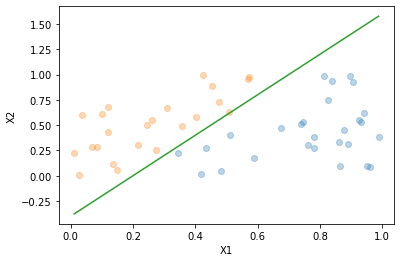

In [150]:
#Xtr,ytr = criaDatasetDummyFeatures(n=50)
Xtr,ytr = criaDataset(n=50)
plotDataset(Xtr,ytr)
plotHiperplano(Xtr,ytr,np.array([2,-1]),-0.4)
Xtr.shape,ytr.shape

0.98
[-0.874862    2.73581266 -1.06776596]


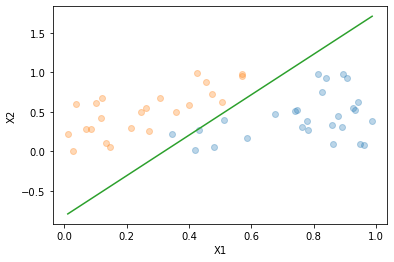

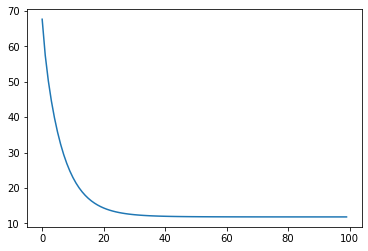

In [151]:
perceptron = Perceptron(DescidaGradiente(learning_rate=0.02,max_iter=100))
history = perceptron.fit(Xtr,ytr)
ypred = perceptron.predict(Xtr)
print(sum(ypred==ytr)/len(ytr))
print(perceptron.w)
plotDataset(Xtr,ytr)
plotHiperplano(Xtr,ytr,perceptron.w[1:],perceptron.w[0])
plt.show()
plotHistory(history)

1.0
[-0.75060309  3.30380856 -1.50282551]


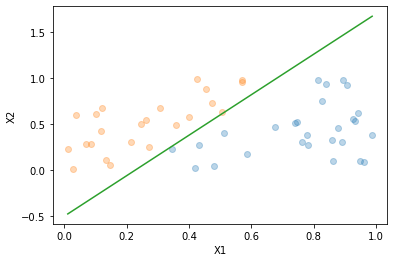

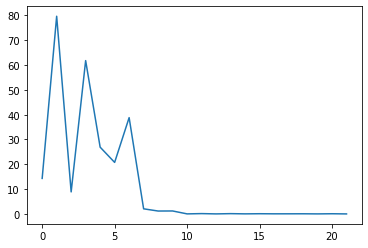

In [152]:
perceptron = Perceptron(DescidaGradiente(learning_rate=0.05,max_iter=1000,cost=SmoothedSurrogate()))
history = perceptron.fit(Xtr,ytr)
ypred = perceptron.predict(Xtr)
print(sum(ypred==ytr)/len(ytr))
print(perceptron.w)
plotDataset(Xtr,ytr)
plotHiperplano(Xtr,ytr,perceptron.w[1:],perceptron.w[0])
plt.show()
plotHistory(history)

0.98
[-2.49877867  9.57094169 -4.31039934]


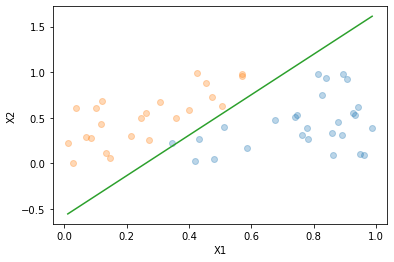

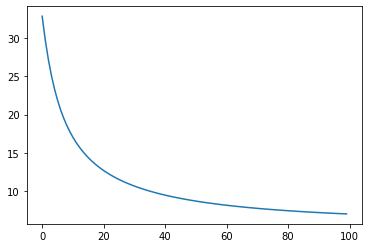

In [153]:
perceptron = Perceptron(DescidaGradiente(learning_rate=0.05,max_iter=100,cost=LogLikehood()))
history = perceptron.fit(Xtr,ytr)
ypred = perceptron.predict(Xtr)
print(sum(ypred==ytr)/len(ytr))
print(perceptron.w)
plotDataset(Xtr,ytr)
plotHiperplano(Xtr,ytr,perceptron.w[1:],perceptron.w[0])
plt.show()
plotHistory(history)

0.98
[-1.83632485  7.07781369 -3.28400276]


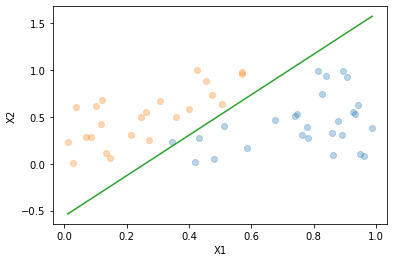

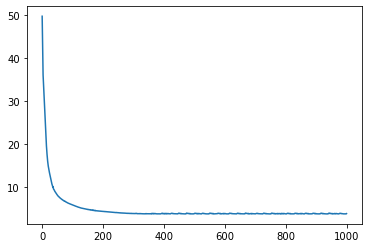

In [156]:
perceptron = Perceptron(DescidaGradiente(learning_rate=0.02,max_iter=1000,cost=HingeLoss()))
history = perceptron.fit(Xtr,ytr)
ypred = perceptron.predict(Xtr)
print(sum(ypred==ytr)/len(ytr))
print(perceptron.w)
plotDataset(Xtr,ytr)
plotHiperplano(Xtr,ytr,perceptron.w[1:],perceptron.w[0])
plt.show()
plotHistory(history)